In [2]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


env = gym.make('CartPole-v0').unwrapped

# matplotlib 설정
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# GPU를 사용할 경우
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """transition 저장"""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [4]:
class DQN(nn.Module):

    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # Linear 입력의 연결 숫자는 conv2d 계층의 출력과 입력 이미지의 크기에
        # 따라 결정되기 때문에 따로 계산을 해야합니다.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)

    # 최적화 중에 다음 행동을 결정하기 위해서 하나의 요소 또는 배치를 이용해 호촐됩니다.
    # ([[left0exp,right0exp]...]) 를 반환합니다.
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

C:\Users\snowjam1994\.conda\envs\torch\lib\site-packages\torchvision\transforms\transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


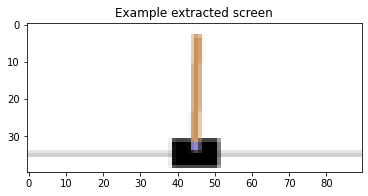

In [6]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])


def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

def get_screen():
    # gym이 요청한 화면은 400x600x3 이지만, 가끔 800x1200x3 처럼 큰 경우가 있습니다.
    # 이것을 Torch order (CHW)로 변환한다.
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    # 카트는 아래쪽에 있으므로 화면의 상단과 하단을 제거하십시오.
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # 카트를 중심으로 정사각형 이미지가 되도록 가장자리를 제거하십시오.
    screen = screen[:, :, slice_range]
    # float 으로 변환하고,  rescale 하고, torch tensor 로 변환하십시오.
    # (이것은 복사를 필요로하지 않습니다)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # 크기를 수정하고 배치 차원(BCHW)을 추가하십시오.
    return resize(screen).unsqueeze(0).to(device)


env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

In [7]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

# AI gym에서 반환된 형태를 기반으로 계층을 초기화 하도록 화면의 크기를
# 가져옵니다. 이 시점에 일반적으로 3x40x90 에 가깝습니다.
# 이 크기는 get_screen()에서 고정, 축소된 렌더 버퍼의 결과입니다.
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

# gym 행동 공간에서 행동의 숫자를 얻습니다.
n_actions = env.action_space.n

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max (1)은 각 행의 가장 큰 열 값을 반환합니다.
            # 최대 결과의 두번째 열은 최대 요소의 주소값이므로,
            # 기대 보상이 더 큰 행동을 선택할 수 있습니다.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # 100개의 에피소드 평균을 가져 와서 도표 그리기
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # 도표가 업데이트되도록 잠시 멈춤
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

In [8]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). 이것은 batch-array의 Transitions을 Transition의 batch-arrays로
    # 전환합니다.
    batch = Transition(*zip(*transitions))

    # 최종이 아닌 상태의 마스크를 계산하고 배치 요소를 연결합니다
    # (최종 상태는 시뮬레이션이 종료 된 이후의 상태)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Q(s_t, a) 계산 - 모델이 Q(s_t)를 계산하고, 취한 행동의 열을 선택합니다.
    # 이들은 policy_net에 따라 각 배치 상태에 대해 선택된 행동입니다.
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # 모든 다음 상태를 위한 V(s_{t+1}) 계산
    # non_final_next_states의 행동들에 대한 기대값은 "이전" target_net을 기반으로 계산됩니다.
    # max(1)[0]으로 최고의 보상을 선택하십시오.
    # 이것은 마스크를 기반으로 병합되어 기대 상태 값을 갖거나 상태가 최종인 경우 0을 갖습니다.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # 기대 Q 값 계산
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Huber 손실 계산
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # 모델 최적화
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [9]:
num_episodes = 50
for i_episode in range(num_episodes):
    # 환경과 상태 초기화
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        # 행동 선택과 수행
        action = select_action(state)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        # 새로운 상태 관찰
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # 메모리에 변이 저장
        memory.push(state, action, next_state, reward)

        # 다음 상태로 이동
        state = next_state

        # 최적화 한단계 수행(목표 네트워크에서)
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
    #목표 네트워크 업데이트, 모든 웨이트와 바이어스 복사
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
env.render()
env.close()
plt.ioff()
plt.show()

<Figure size 432x288 with 0 Axes>

Complete


<Figure size 432x288 with 0 Axes>

In [12]:
a = input()


0 3


In [13]:
a


'0 3'